<a href="https://colab.research.google.com/github/erodola/DLAI-s2-2023/blob/main/labs/04/4_Logistic_Regression_and_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning & Applied AI

# Tutorial 4: Logistic Regression and Optimization

In this tutorial, we will cover:

- Logistic regression
- Optimization, parameters tuning, weight decay, learning rate decay, loss landscape

Based on original material by Dr. Luca Moschella, Dr. Antonio Norelli, and Dr. Marco Fumero.

Course:

- Website and notebooks will be available at https://github.com/erodola/DLAI-s2-2024/

⚠️ **Compatibility warning:**
- For this notebook we are downgrading to plotly 5.11.0, because some plots stopped working with later versions. This is taken care of in the import dependencies cell below.

# Imports and utilities

In [14]:
# @title import dependencies

!pip install plotly==5.11.0

from typing import Mapping, Union, Optional, Tuple

import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import plotly.graph_objects as go
import torchvision

from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [15]:
# @title reproducibility stuff

import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(0)

torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.benchmark = False

In [16]:
# @title some non-convex functions we'll use

from typing import Callable, Union, Sequence
import math

def peaks(xx: torch.Tensor, yy: torch.Tensor) -> torch.Tensor:
  """
  "Peaks" function that has multiple local minima.
  """
  xx = torch.as_tensor(xx)
  yy = torch.as_tensor(yy)
  return (0.25 * (3*(1-xx)**2*torch.exp(-xx**2 - (yy+1)**2) -
                  10*(xx/5 - xx**3 - yy**5)*torch.exp(-xx**2-yy**2) -
                  1/3*torch.exp(-(xx+1)**2 - yy**2)))

def rastrigin(xx: torch.Tensor, yy: torch.Tensor, shift: int = 0) -> torch.Tensor:
  """
  "Rastrigin" function with `A = 3`
  https://en.wikipedia.org/wiki/Rastrigin_function
  """
  xx = torch.as_tensor(xx)
  yy = torch.as_tensor(yy)
  A = 3
  return A * 2 + (((xx - shift) ** 2 - A * torch.cos(2 * torch.tensor(math.pi, dtype=torch.float, device=xx.device) * xx))
                  +
                  ((yy - shift) ** 2 - A * torch.cos(2 * torch.tensor(math.pi, dtype=torch.float, device=xx.device) * yy)))

def rosenbrock(xx: torch.Tensor, yy: torch.Tensor) -> torch.Tensor:
  """
  "Rosenbrock" function
  https://en.wikipedia.org/wiki/Rosenbrock_function

  It has a global minimum at $(x , y) = (a, a^2) = (1, 1)$
  """
  xx = torch.as_tensor(xx)
  yy = torch.as_tensor(yy)

  a = 1
  b = 100
  return (a - xx) ** 2 + b * (yy - xx**2)**2

In [17]:
# @title utility functions for plotting


def plot_landscape(
    fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    resolution: int = 100,
    lim: int = 3,
    height: int = 900,
    landscape_opacity: float = 1.0,
    title: Optional[str] = None,
    autoshow: bool = False,
    xaxis_title="x",
    yaxis_title="y",
    zaxis_title = None,
    **kwargs
) -> go.Figure:
    """ Plot the landscape defined by the universal function `fn`.

    Creates a domain grid $x,y \in R^2$ with $x \in [-lim, lim]$ and
    $y \in [-lim, lim]. The number of points in this grid is resolution**2.
    """
    xx = torch.linspace(-lim, lim, resolution)
    yy = torch.linspace(-lim, lim, resolution)
    zz = fn(xx[None, :], yy[:, None], **kwargs)

    xx = xx.cpu().detach()
    yy = yy.cpu().detach()
    zz = zz.cpu().detach()

    fig = go.Figure(data=[go.Surface(z=zz, x=xx, y=yy, opacity=landscape_opacity)])
    fig.update_traces(
        contours_z=dict(
            show=True, usecolormap=True, highlightcolor="lightgray", project_z=True
        )
    )
    fig.update_layout(
        title=f"{fn.__name__.title()} landscape" if title is None else title,
        height=height,
        scene=dict(
            xaxis_title=xaxis_title,
            yaxis_title=yaxis_title,
            zaxis_title=f"{fn.__name__}(x, y)" if zaxis_title is None else zaxis_title,
        ),
    )

    if autoshow:
      fig.show()
    return fig


def plot_point_over_landscape(
    fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    point: Tuple[float, float] = None,
    resolution: int = 100,
    lim: int = 3,
    landscape_opacity: float = 1.0,
    height: int = 900,
    title: Optional[str] = None,
    xaxis_title="x",
    yaxis_title="y",
    zaxis_title = None,
    autoshow: bool = False,
) -> go.Figure:
    """ Plot a point over the landascape defined by the cunction `fn`

  :param fn: a universal function $R^2 -> R$
  :param point: if not None, marks the point with a red dot
  :param title: the title of the plots, if None defaults to  the fn name
  :param autoshow: if True, calls fig.show() before returning the figure

  :retuns: the figure that contains the plot
  """
    fig = plot_landscape(
        fn,
        resolution=resolution,
        lim=lim,
        height=height,
        landscape_opacity=landscape_opacity,
        title=title,
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        zaxis_title=zaxis_title,
    )

    # Create starting path
    x_point, y_point = (float(p) for p in point)
    fig.add_trace(
        go.Scatter3d(
            visible=True,
            showlegend=False,
            mode="markers",
            marker=dict(size=6, color="white", symbol="circle"),
            x=[x_point],
            y=[y_point],
            z=[fn(x_point, y_point).cpu().detach()],
        )
    )

    if autoshow:
        fig.show()

    return fig


# awesome functions 👀


def plot_path_over_landscape(
    fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    x_path: Union[torch.Tensor, Sequence[float]],
    y_path: Union[torch.Tensor, Sequence[float]],
    global_minimum: Tuple[float, float] = None,
    resolution: int = 100,
    lim: int = 3,
    height: int = 900,
    landscape_opacity: float = 1.0,
    title: Optional[str] = None,
    xaxis_title="x",
    yaxis_title="y",
    zaxis_title = None,
    autoshow: bool = False,
) -> go.Figure:
    """ Plot a path over the landascape defined by the cunction `fn`

  :param fn: a universal function $R^2 -> R$ (must support broadcasting between x, y)
  :param x_path: the x coordinate of each point in the path
  :param y_path: the y coordinate of each point in the path
  :param global_minimum: if not None, marks the point with a red dot
  :param resolution: the resolution of the R^2 domain
  :param lim: the limits of the R^2 domain (symmetric around 0 in x and y)
  :param height: the height of the figure
  :param landscape_opacity: the landscape plot opacity
  :param title: the title of the plots, if None defaults to  the fn name
  :param autoshow: if True, calls fig.show() before returning the figure

  :retuns: the figure that contains the plot
  """
    fig = plot_landscape(
        fn,
        resolution=resolution,
        lim=lim,
        height=height,
        landscape_opacity=landscape_opacity,
        title=title,
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        zaxis_title=zaxis_title,
    )

    x_path = torch.as_tensor(x_path, dtype=torch.float)
    y_path = torch.as_tensor(y_path, dtype=torch.float)
    z_path = fn(x_path, y_path)

    # Create starting path
    fig.add_trace(
        go.Scatter3d(
            visible=True,
            showlegend=False,
            marker=dict(size=4, color="white", symbol="circle"),
            line=dict(color="lightgray", width=3),
            x=x_path[0:1],
            y=y_path[0:1],
            z=z_path[0:1],
        )
    )
    # If you find out how to project the path onto the landscape contour, tell us! :]

    if global_minimum is not None:
        x_point, y_point = (float(p) for p in global_minimum)

        # Create the goal marker
        fig.add_trace(
            go.Scatter3d(
                visible=True,
                showlegend=False,
                mode="markers",
                marker=dict(size=3, color="red", symbol="circle"),
                x=[x_point],
                y=[y_point],
                z=[fn(x_point, y_point).cpu().detach()],
            )
        )

    # Create frames that modify the starting path
    frames = []
    for j in np.arange(1, z_path.shape[0]):
        frames.append(
            go.Frame(
                name=f"frame{j}",
                traces=[1],
                data=[go.Scatter3d(x=x_path[:j], y=y_path[:j], z=z_path[:j],)],
            )
        )

    # Create the slider to start the animation at different timesteps
    sliders = [
        dict(
            steps=[
                dict(
                    method="animate",  # Sets the Plotly method to be called when the
                    # slider value is changed.
                    args=[
                        [f"frame{k}"],  # Sets the arguments values to be passed to
                        # the Plotly method set in method on slide
                        dict(
                            mode="immediate",
                            frame=dict(duration=50, redraw=False),
                            transition=dict(duration=0),
                        ),
                    ],
                    label=f"{k}",
                )
                for k in range(z_path.shape[0] - 1)
            ],
            currentvalue={"prefix": "Iteration: "},
        )
    ]
    # If you find out how to fix the slider let us know :]

    fig["layout"]["sliders"] = sliders
    fig["layout"]["updatemenus"] = [
        dict(
            type="buttons",
            pad={"r": 10, "t": 70},
            showactive=False,
            buttons=[
                dict(
                    label="Play",
                    method="animate",
                    args=[
                        None,
                        dict(
                            frame=dict(duration=500, redraw=True),
                            transition=dict(duration=0),
                            fromcurrent=True,
                            mode="immediate",
                        ),
                    ],
                ),
                dict(
                    label="Pause",
                    method="animate",
                    args=[[None], dict(mode="immediate")],
                ),
            ],
        )
    ]

    fig["frames"] = frames

    if autoshow:
        fig.show()

    return fig


def plot_optimization(
    fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    start: Tuple[float, float],
    opt: torch.optim.Optimizer,
    opt_args: Mapping[str, Union[float, str]],
    n_steps: int = 50,
    goal: Tuple[float, float] = None,
    device: Optional[str] = None,
    resolution: int = 100,
    lim: int = 3,
    height: int = 900,
    landscape_opacity: float = 1.0,
    title: Optional[str] = None,
    autoshow: bool = False,
) -> go.Figure:
    """
    Run an optimization process and plot the optimization path

    :param fn: a universal function $R^2 -> R$ (must support broadcasting between x, y)
    :param start: the starting point to optimize
    :param opt: the optimizer to use
    :param opt_args: the arguments to use for the current optimizers
    :param n_steps: the number of steps to perform in this optimization process
    :param goal: if not None, mark the point that represents the goal of the optimization
    :param device: the device to use, if None defaults to 'cuda' if available
    :param resolution: the resolution of the R^2 domain
    :param lim: the limits of the R^2 domain (symmetric around 0 in x and y)
    :param height: the height of the figure
    :param landscape_opacity: the landscape plot opacity
    :param title: the title of the plots, if None defaults to  the fn name

    :param autoshow: if True, calls fig.show() before returning the figure

    :returns: the figure with the landscape and the optimization path
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    x = torch.tensor(start[0], device=device, dtype=torch.float, requires_grad=True)
    y = torch.tensor(start[1], device=device, dtype=torch.float, requires_grad=True)
    x_line = [x.cpu().detach().item()]
    y_line = [y.cpu().detach().item()]

    opt = opt([x, y], **opt_args)

    for i in tqdm(range(n_steps), desc="Optimization"):
        out = fn(x, y)
        out.backward()
        opt.step()
        opt.zero_grad()
        x_line.append(x.item())
        y_line.append(y.item())

    f = plot_path_over_landscape(
        fn,
        x_line,
        y_line,
        global_minimum=goal,
        resolution=resolution,
        lim=lim,
        height=height,
        landscape_opacity=1,
        title=title,
        autoshow=autoshow,
    )
    return f


# Logistic Regression

### Classifying handwritten digits
Today we start with the *Hello world!* of deep learning, classifying MNIST digits using logistic regression.

## Data loading

We can either download the dataset ourselves, directly from Yann LeCun's website, or let the torchvision library do the job for us.

Direct download would involve calling these functions:

In [18]:
# Here we are using a mirror for the official MNIST website
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2024-03-19 13:02:49--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2024-03-19 13:02:49--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [           <=>      ]  33.20M  7.64MB/s    in 4.9s    

2024-03-19 13:02:55 (6.72 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

...and then you would have to put together a pytorch Dataset for training and test data and make sure it does what you wanted.

Alternatively, we can use torchvision `datasets.MNIST`, which already inherits from torch `Dataset`, to do the job more quickly. Let's do that!

In [19]:
train_dataset = datasets.MNIST(
    './',
    train=True,
    download=True,
    transform=transforms.Compose([
        # tranforming images to pytorch tensors
        transforms.ToTensor(),

        # normalizing the tensors, i.e. the distribution of values on each sample should have mean=0.1307 and stddev=0.3081,
        # corresponding to the mean and stddev of the whole MNIST dataset.
        # Check https://stats.stackexchange.com/questions/211436/why-normalize-images-by-subtracting-datasets-image-mean-instead-of-the-current
        # for an intuition.
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_dataset = datasets.MNIST('./', train=False,
                    transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])
                )

## Data exploration

It is always a good idea to look at some entries in the dataset.

**Note:** `train_dataset` and `test_dataset` are objects of the `torchvision.datasets.MNIST` class. Check the [docs](https://pytorch.org/vision/0.16/generated/torchvision.datasets.MNIST.html) to see how to use them!

In [20]:
import plotly.express as px
import numpy as np

mnist_example = train_dataset[42][0][0].numpy()
print('A MNIST sample has size', mnist_example.shape)
fig = px.imshow(mnist_example)
fig.show()

A MNIST sample has size (28, 28)


**Is this a 1 or a 7?**

This is the existential question we will try to answer today.

Let's proceed by selecting only the 1 and 7 samples from the MNIST dataset.





In [21]:
for dataset in [train_dataset, test_dataset]:
    mask_sevens = dataset.targets == 7
    mask_ones = dataset.targets == 1

    # re-map 7s to have label 0 and 1s to have label 1
    dataset.targets[mask_sevens] = 0
    dataset.targets[mask_ones] = 1

    # only keep 7s and 1s
    dataset.targets = dataset.targets[mask_sevens + mask_ones]
    dataset.data = dataset.data[mask_sevens + mask_ones]

Let's wrap the dataset in a pytorch DataLoader.

Notice that by using `batch_size=len(dataset)`, each batch contains the entire dataset. This is not common, we are doing this here just because we don't really need smaller batches today.

In [22]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)


How difficult is this task?

>It is always important to have an idea of how much *intelligence* you expect from your AI application.

How can you make that estimate? Often a simple solution is at your fingertips...

>**EXERCISE (warm-up)**: Combine several samples in a grid and plot a big picture. Then try to classify each one as a 1 or a 7, using your own judgement. What is your classification accuracy?

Even the best spend their time classifying images by hand... ([Imagenet and Andrej Karpathy](http://karpathy.github.io/2014/09/02/what-i-learned-from-competing-against-a-convnet-on-imagenet/), director of AI at Tesla).


In [23]:
# ✏️ your code here
# hint: use `torchvision.utils.make_grid` and `px.imshow`

images = next(iter(train_dataloader))  # we only get one batch of data, since it contains the entire dataset
# ...


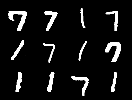

In [24]:
# @title 👀 Solution  { run: "auto" }

cols = 4  #@param {type:"slider", min:1, max:8, step:1}
rows = 3 #@param {type:"slider", min:1, max:4, step:1}

grid_images = images[0][:rows*cols, ...]
resolved_grid = torchvision.utils.make_grid(grid_images, padding=4, nrow=cols, normalize=True, value_range=(0, 1))
px.imshow(resolved_grid.permute(1, 2, 0))

## Building the model

Given a dataset $(\mathbf{X}, \mathbf{t})$ where $\mathbf{X} \in \mathbb{R}^{N \times k}$ encodes $N$ data points and $\mathbf{t} \in [0,1]^N$ the corresponding ground-truth labels, the prediction of a logistic regression model with $\theta = \{\mathbf{a}, b\}$, on a sample $\mathbf{x}_i$ is:
$$f_\theta(\mathbf{x}_i) = \sigma(\mathbf{a}^\top\mathbf{x}_i + b)\,,$$

with $\sigma$ being the logistic sigmoid.

Such predictions are evaluated by the following loss function, which we fully derived in class:
$$ E(\theta) = - \frac{1}{N}\sum_{i=1}^N t_i \ln(f_\theta(\mathbf{x}_i)) + (1 - t_i)\ln(1 - f_\theta(\mathbf{x}_i)) $$

This loss is commonly called **cross-entropy error**. Familiarize with this term, because it appears all the time!

We are going to minimize the loss by following the opposite direction of the gradient of $E(\theta)$, starting from an initial configuration $\theta_0$. Recall that the gradient is defined as:

$$\nabla E(\theta) = (\frac{\partial E}{\partial a_1}, \frac{\partial E}{\partial a_2}, ... , \frac{\partial E}{\partial a_k}, \frac{\partial E}{\partial b})$$

Note that the logistic regression model we defined above, expects the data points $\textbf{x}_i$ to be $k$-dimensional vectors. We can fit this format by flattening each image to a simple vector:

![polyfit matrix notation](https://drive.google.com/uc?export=view&id=1uPlydRr82rgjd7pr04aBXl8SwEgrwK7I)

We do this [with great reluctance](https://i.pinimg.com/originals/bd/a5/ef/bda5ef59a353d077c07a2f154f9c595a.jpg), because the flattening operation won't allow us to take advantage of patterns that are simple in 2D but become very intricate in 1D, making learning harder. When we'll reach CNNs, we'll see how image structure actually forms a strong prior for learning!

Let's compute the predictions of our logistic regression model for a set of samples $\mathbf{X}$, and also the gradient $\nabla E(\theta)$ .

>**EXERCISE**: Complete the function below. The input to the function is a tensor `theta` of parameters (e.g., resulting from a previous iteration of gradient descent), the data points stored in a matrix `X`, and the ground-truth labels `t` for each data point.
>
> Recall that the prediction for a given data point is just a _scalar_, i.e. its predicted class.

In [25]:
# ✏️ your code here

def lr_predictions_and_gradient(theta, X, t):
    """
    Logistic regression predictions and gradient on MNIST
    Arguments:
    theta -- parameters, a torch tensor of size (28 * 28 + 1), the last is the bias
    X -- data, a torch tensor of size (number of examples, 28, 28)
    t -- true "label" vector (containing 0 if seven, 1 if one), a torch tensor of size (number of examples)

    Return:
    loss -- negative log-likelihood loss, a torch tensor of size (1)
    dtheta -- gradient of the loss with respect to theta, a torch tensor of size (28 * 28 + 1)
    pred -- model predictions, a torch tensor of size (number of examples)
    """

    # GENERAL IDEA:
    #
    # Start by computing the loss.
    #
    # First think of how you would write the loss for one sample, then extend the computation
    # to all other samples _without_ using a for loop. It's just simple matrix operations.
    #
    # Recall that you don't have to return only the loss, but also all the predicted classes.
    #
    # For the gradient, don't make it harder than necessary: it's a simple formula, really.

    # Predictions (from X to loss)
    # hint: add a column of ones to X to manage the bias


    # Gradient

    assert dtheta.shape == theta.shape

    return loss, dtheta, pred


# # testing the function, you should obtain loss = 1.127, torch.sum(gradient) = 57.592
# X, t = next(iter(train_dataloader))
# theta = torch.ones(28*28+1) / 100

# loss, gradient, _ = lr_predictions_and_gradient(theta, X, t)
# print('loss:', loss, 'gradient:', torch.sum(gradient))

> [Math hint for the gradients](https://medium.com/mathematics-behind-optimization-of-cost-function/derivative-of-log-loss-function-for-logistic-regression-9b832f025c2d)  👀

In [26]:
# @title Solution 👀

def lr_predictions_and_gradient(theta, X, t):
    """
    Logistic regression predictions and gradient on MNIST
    Arguments:
    theta -- parameters, a torch tensor of size (28 * 28 + 1), the last is the bias
    X -- data, a torch tensor of size (number of examples, 28, 28)
    t -- true "label" vector (containing 0 if seven, 1 if one), a torch tensor of size (number of examples)

    Return:
    loss -- negative log-likelihood loss, a torch tensor of size (1)
    dtheta -- gradient of the loss with respect to theta, a torch tensor of size (28 * 28 + 1)
    pred -- model predictions, a torch tensor of size (number of examples)
    """

    N = X.shape[0]
    X = X.reshape(N, -1)

    # Predictions (from X to loss)
    # hint: add a column of ones to X to manage the bias

    new_X = torch.cat((X, torch.ones((N, 1))), dim=1)
    pred = torch.sigmoid(torch.einsum('i,ji->j', theta, new_X)) # contains the (scalar) predictions for all data points
    loss = (- 1 / N) * torch.sum(t * torch.log(pred) + (1 - t) * (torch.log(1 - pred)))

    # Gradient
    dtheta = (1 / N) * torch.einsum('ji,j->i', new_X, pred - t)

    assert dtheta.shape == theta.shape

    return loss, dtheta, pred


# testing the function, you should obtain loss = 1.127, torch.sum(gradient) = 57.592
X, t = next(iter(train_dataloader))
theta = torch.ones(28*28+1) / 100

loss, gradient, _ = lr_predictions_and_gradient(theta, X, t)
print('loss:', loss, 'gradient:', torch.sum(gradient))

loss: tensor(1.1268) gradient: tensor(57.5922)


#### Visualizing the weights

Did you notice that we have as many weights as we have pixels in our image? Recall the logistic regression model:

$$f_\theta(\mathbf{x}_i) = \sigma(\mathbf{a}^\top\mathbf{x}_i + b)\,,$$

This suggests that we can reshape the set of weights (just the $\mathbf{a}$) as an image, and have a look at them!

In [43]:
px.imshow(theta[:-1].reshape(28, 28))

Can you read the image?

####Optimizing the model

We will search the optimal $\theta$ through naive gradient descent (GD, $m = N$) and stochastic gradient descent (SGD, $m < N$).
$$\theta^{(t+1)} = \theta^{(t)} - \alpha \nabla E(\theta^{(t)})$$
with
$$\nabla E(\theta^{(t)}) = \frac{1}{m} \sum_i^m \nabla E_{\theta^{(t)}}(\{\mathbf{x}_i, t_i\}) $$

We implemented SGD for you, so for the moment you can ignore the code below and just concentrate on the qualitative aspects.

Feel free to play with two relevant parameters of the optimization:
- the batch size $m$.
- the number of *epochs*, each having $ \frac{N}{m} $ steps  (A single step of naive GD is an epoch!)

See how noisy the SGD training loss is, especially with small batch sizes. Why is that? Also look at the test loss!

In [29]:
# @title Logistic regression: epochs and batch size (⚠️doesn't work with plotly >5.11.0) { run: "auto" }

num_epochs = 9  #@param {type:"slider", min:1, max:20, step:1}
batch_size_1 = "500"  #@param ["1", "2", "3", "5", "10", "50", "100", "500", "1000", "6500", "13007"]
batch_size_2 = "13007"  #@param ["1", "2", "3", "5", "10", "50", "100", "500", "1000", "6500", "13007"]
plot_log_scale = False  #@param {type:"boolean"}

learning_rate = 0.01
theta_init = torch.randn(28*28+1) / 100

X, t = next(iter(train_dataloader))
X_test, t_test = next(iter(test_dataloader))
fig = go.Figure()

for batch_size in [int(batch_size_1), int(batch_size_2)]:
    steps_per_epoch = int(X.shape[0] / batch_size)
    # X_slices = torch.chunk(X, steps_per_epoch)
    # t_slices = torch.chunk(t, steps_per_epoch)
    train_losses = []
    test_losses = []
    theta = theta_init
    print(f'Training with batch size: {batch_size}')
    for i in tqdm(range(num_epochs)):
        for j in range(steps_per_epoch):
            slice_batch = torch.arange((j * batch_size), ((j + 1) * batch_size), 1)
            train_loss, gradient, _ = lr_predictions_and_gradient(theta, X[slice_batch], t[slice_batch])
            theta = theta - learning_rate * gradient
            train_losses.append(train_loss.numpy())

            test_loss, _, pred_test = lr_predictions_and_gradient(theta, X_test, t_test)
            test_losses.append(test_loss.numpy())
        if i % (int(num_epochs / 5) + 1) == 0:
            print(f'\tEpoch {i}\tTrain loss: {float(train_loss):.5f}\tTest loss: {float(test_loss):.5f}')

    test_accuracy = float(100 - torch.mean(torch.abs(pred_test - t_test)) * 100)
    print(f'\tFinal test accuracy: {test_accuracy:.2f} %')

    x = np.arange(num_epochs * steps_per_epoch) / steps_per_epoch * 100
    fig.add_trace(go.Scatter(x=x, y=train_losses, name=f'training loss, bs: {batch_size}'))
    fig.add_trace(go.Scatter(x=x, y=test_losses, name=f'test loss, bs: {batch_size}'))

fig.update_layout(title='Loss per epoch', xaxis_title='100 * epoch', yaxis_title='loss')
if plot_log_scale:
    fig.update_xaxes(type="log")

fig.show()  # for some reason this doesn't work with plotly >5.11.0!

Training with batch size: 500


  0%|          | 0/9 [00:00<?, ?it/s]

	Epoch 0	Train loss: 0.12411	Test loss: 0.11536
	Epoch 2	Train loss: 0.08040	Test loss: 0.07032
	Epoch 4	Train loss: 0.06876	Test loss: 0.05753
	Epoch 6	Train loss: 0.06290	Test loss: 0.05088
	Epoch 8	Train loss: 0.05925	Test loss: 0.04663
	Final test accuracy: 96.67 %
Training with batch size: 13007


  0%|          | 0/9 [00:00<?, ?it/s]

	Epoch 0	Train loss: 0.58989	Test loss: 0.46571
	Epoch 2	Train loss: 0.38464	Test loss: 0.33228
	Epoch 4	Train loss: 0.29243	Test loss: 0.26501
	Epoch 6	Train loss: 0.24099	Test loss: 0.22465
	Epoch 8	Train loss: 0.20810	Test loss: 0.19764
	Final test accuracy: 83.33 %


### Code take-aways

Time to peek into that code! Open the code cell and look for the parts where we do the following:

- We initialize GD/SGD with **random parameters**.
- The difference between GD and SGD is only in **the batch size**!
- With SGD, we slice the data tensor to **only compute $m$ gradients**; this makes it way more efficient!

### Optimal batch size

Although with GPUs we can compute almost $K$ gradients $\nabla E_{\theta^{(t)}}(\{\mathbf{x}_i, t_i\})$ at the same speed of a single gradient $\nabla E_{\theta^{(t)}}(\{\mathbf{x}_i, t_i\})$ (as long as the samples $(\{\mathbf{x}_1, t_1\}, ... , \{\mathbf{x}_K, t_K\})$ fit in the GPU memory), generally in deep learning you do not want mini-batches to be too large.

$$
\text{You want a noisy approximation of the gradients.}
$$

$$
\text{You do not want to reach the global minimum of the loss.}
$$

In fact, at the global minimum, an overparametrized model like a deep neural network would overfit big time.

 Quoting the work of Keskar et al. [*On Large-Batch Training for Deep Learning: Generalization Gap and Sharp Minima*](https://ar5iv.org/abs/1609.04836):

>The stochastic gradient descent (SGD) method and its variants are algorithms of choice for many Deep Learning tasks. These methods operate in a small-batch regime wherein a fraction of the training data, say 32-512 data points, is sampled to compute an approximation to the gradient. It has been observed in practice that when using a larger batch there is a degradation in the quality of the model, as measured by its ability to generalize. We investigate the cause for this generalization drop in the large-batch regime and present numerical evidence that supports the view that large-batch methods tend to converge to sharp minimizers of the training and testing functions - and as is well known, sharp minima lead to poorer generalization. In contrast, small-batch methods consistently converge to flat minimizers, and our experiments support a commonly held view that this is due to the inherent noise in the gradient estimation.

Nevertheless, the optimal size of a mini-batch is still debated and many interesting works have been published in the last years, for instance:

- [*Don't Decay the Learning Rate, Increase the Batch Size*](https://ar5iv.org/abs/1711.00489)
- [*Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour*](https://arxiv.org/abs/1706.02677)

#### Misclassified samples
Another good practice is to look for the samples where your trained model fails. Do you spot some trends?

*In this test, we use the model trained with the value of `batch_size_2` set in the previous cell. Run that part again before running this test.*

In [45]:
X_test, t_test = next(iter(test_dataloader))

counter = 0
num_examples = 5  #@param {type:"slider", min:1, max:50, step:1}
for i in range(X_test.shape[0]):
    loss, _, pred = lr_predictions_and_gradient(theta, X_test[i], t_test[i])
    if loss > 1:  # let's plot misclassified samples only
        counter += 1
        print(f'sample {i}\tprediction: {float(pred):.2f}\tground truth: {t_test[i]}')
        fig = px.imshow(X_test[i][0].numpy())
        fig.update_layout(width=100, height=100, margin=dict(l=10, r=10, b=10, t=10))
        fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
        fig.show()
        if counter == num_examples:
            break

sample 26	prediction: 0.72	ground truth: 0


sample 168	prediction: 0.71	ground truth: 0


sample 277	prediction: 0.73	ground truth: 0


sample 345	prediction: 0.81	ground truth: 0


sample 389	prediction: 0.73	ground truth: 0


It would be nice being able to do tests more quickly, so that we don't have to wait forever for any little change we bring to our hyper-parameters such as the batch size!

Being faster is crucial with larger models and datasets. Let's take a look at the tools of the trade.

# Optimization



In this section you will learn how different GD-based optimizers and their parameters drastically change the optimization process, both in speed and convergence.

When looking for a minimum of a function $f$, a GD-based optimizer explores different configurations of parameters $x$, starting from a point $x^{(0)}$ and using only the *local* information provided by the gradients $\nabla f (x^{(t)})$.

As seen in the previous lesson (or the next one), the next configuration $x^{(t+1)}$ explored by all the common optimizers (e.g. SGD, RMSprop, Adam, ...) can be written as:

$$
x^{(t+1)} = x^{(0)} + \alpha \sum_{i=0}^{t} \Gamma_i^t  \nabla f (x^{(t)})
$$

We have:

- $\alpha$ the learning rate hyperparameter, i.e. how much the gradients should be magnified.
- $\Gamma$ the momentum hyperparameter, i.e. how much the past gradients should be considered.


## Context

Deep learning involves **non-linear optimization**.

In this section you will explore GD-based optimizers and their parameters on simple non-parametric functions $f: \mathbb{R}^2 \to \mathbb{R}$ .

Let's see an example (click on `play` -- ⚠️doesn't work with plotly >5.11.0):

In [46]:
plot_optimization(fn=peaks, start=(0.0, 1.2), opt=torch.optim.Adam, opt_args={'lr': 0.75})

Optimization:   0%|          | 0/50 [00:00<?, ?it/s]

## A step-by-step example

Let's take a look at how we can perform this kind of optimizations in PyTorch.


We are going to **define an arbitrary function** $f: \mathbb{R}^2 \to \mathbb{R}$ and **a starting point** for our optimization:

In [47]:
# Define an arbitrary function
def fancy_function(xx: torch.Tensor, yy: torch.Tensor):
  xx = torch.as_tensor(xx)
  yy = torch.as_tensor(yy)
  return -torch.cos(xx) + torch.sin(yy) +  0.1 * (xx**2 + 2*yy**2)

# Define a starting point
start = (-4, 4)

The function returns a rank-0 PyTorch tensor, not a built-in python scalar! This is important, because we'll have to call PyTorch methods on it.

In [48]:
out = fancy_function(start[0], start[1])
out.shape

torch.Size([])

Let's now visualize our function and the starting point.

In [ ]:
plot_point_over_landscape(fancy_function, point=start, lim=5, height=750)

### Simple gradient descent: introducing `requires_grad` and `backward()`

Now we want to make point $p$ descend the $f$ landscape.

We can easily do this with some ready-made optimizers in `torch.nn.optim`. However, just for this example, we are going to **implement our own gradient descent**.

With this excuse, we'll introduce a key method that will help us compute gradients automagically🪄: the `backward()` method.

Once we have our gradients ready, we will apply gradient updates to the starting point, and so on for each iteration. We need to choose:

- The learning rate $\alpha$
- How many steps we want to execute (alternatively, we could check for convergence).


>**NOTE:** We must explicitly tell PyTorch that we'll compute gradients with respect to the starting point! If `t` is our tensor containing the parameters, we use `requires_grad=True` to tell PyTorch that at some point in our code we will need the gradient of the loss w.r.t. to `t`.
>
> In the next theoretical lessons you will learn *how* the gradient computation is done, and in the next lab you will explore in detail the `autograd` package for automatic differentiation.

In [ ]:
n_steps = 50    # Number of steps
alpha = 3       # The learning rate


# The starting point, with requires_grad=True
x = torch.tensor(start[0], dtype=torch.float, requires_grad=True)
y = torch.tensor(start[1], dtype=torch.float, requires_grad=True)


# While the starting point descends towards the minimum, we want to remember
# each intermediate point, to visualize the path once the optimization ends.
# Thus, we define two variables to mantain the points (x(t),y(t)), and initialize
# them with the starting point.
x_path = [x.item()]
y_path = [y.item()]


# Manual implementation of a simple gradient descent: NOT what we'll use in the future!
for i in tqdm(range(n_steps), desc='Manual optimization'):

  out = fancy_function(x, y)       # Get the current value of the function. 'out' is a rank-0 tensor.

  out.backward()                   # 🪄Compute the partial derivatives and store
                                   # them in x.grad and y.grad. More details next week!

  # We are now going to explicitly update x and y with a GD step.
  # Clearly, we are not interested in computing the gradient *of the update operations themselves*.
  # It sounds obvious, but if we don't tell PyTorch, it will attempt to compute those derivatives!
  # We use the .no_grad() command to do so. More on this next week!

  with torch.no_grad():            # Disable gradient computation since we are only updating the parameters
    x -= alpha * x.grad            # Do in-place update manually
    y -= alpha * y.grad            # Do in-place update manually

    x.grad = None                  # Remember to reset the current gradient.
    y.grad = None                  # Otherwise, the next backward() call will accumulate the gradient with the previous one!

  # Add the new point the the path
  x_path.append(x.item())
  y_path.append(y.item())


# Then, visualize how the starting point moved around the surface
plot_path_over_landscape(fn=fancy_function, x_path=x_path, y_path=y_path, lim=5)

###### **EXERCISE**
>
> Did the optimization reach the minimum?
>
> Change the parameters to make the optimization process converge in less than `50` steps!

###### **EXERCISE**
>
> Implement the momentum mechanism in the previous gradient descent algorithm.
>
> *Note: Don't do this exercise if the theory class has not covered momentum yet.*

##### PyTorch optimizers

It's time to discover the `torch.optim` package to use famous optimizers such as `torch.optim.Adam`.

Every PyTorch optimizer takes, as a first argument, a list of parameters to optimize (hence they must have `requires_grad=True`), plus other hyper-parameters specific to each optimizer, such as the `momentum`, `alpha` or `weight_decay`. They usually have sensible defaults.

---

⚠️ **Momentum *is not* weight decay**

Some optimizers in PyTorch like `torch.optim.Adam` have a `weight_decay` parameter. However, if you look at the [docs](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html), you'll see that this decay is actually a $L_2$ penalty on the optimization parameters. _It's not a decay schedule for the learning rate_. If `weight_decay`$=\lambda$, it's adding a term $\lambda\|\theta\|_2^2$ to the loss.

One way to think about it is that weight decay *regularizes the function* that's being optimized, while momentum *regularizes the path* you take over it.

The integration in the optimizers is a purely implementative and usability-driven choice by PyTorch developers.


---

Let's use the Adam optimizer.

In [ ]:
# Reset the variables, otherwise we would have the starting point *in* the optimum
x = torch.tensor(start[0], dtype=torch.float, requires_grad=True)
y = torch.tensor(start[1], dtype=torch.float, requires_grad=True)
x_path = [x.item()]
y_path = [y.item()]
# -----------------

lr = .5
adam = torch.optim.Adam([x, y], lr=lr)  # Instantiate the optimizer

for i in tqdm(range(n_steps), desc='Adam optimization'):
  out = fancy_function(x, y)            # Get the current value of the function
  out.backward()                        # Compute the partial derivatives
  adam.step()                           # Perfom one optimization step with some fancy rule
  adam.zero_grad()                      # Set the all the parameters grad to zero

  # Add the new point the the path
  x_path.append(x.item())
  y_path.append(y.item())


plot_path_over_landscape(fn=fancy_function, x_path=x_path, y_path=y_path, lim=5)

**Tech tip:** In order to ease the reading and visualization in this notebook,
we decoupled the code that you just saw in the `plot_optimization` function. You can use it to plot the gradient descent paths on your own custom functions.

The simplest call to this function is:
  ```python
  plot_optimization(fn = ...,       # A universal function R^2 -> R
                    start = ...,    # A starting point (x, y)
                    opt = ...,      # An optimizer class from torch.optim
                    opt_args = ..., # A dict with the optimizer hyperparameters
  ```

It requires `fn` to be a _universal_ function, which in Numpy jargon is a function that supports broadcasting of its arguments. In our example, `fancy_function` is universal because it uses element-wise operations like `torch.cos`, `torch.sin` and `*`. Read more in the [docs](https://numpy.org/doc/stable/user/basics.ufuncs.html#ufuncs-basics).

To read the whole docstring of `plot_optimization` just write:

In [ ]:
help(plot_optimization)

###### **EXERCISE**
>
> Define your own function and the starting point to optimize.
>
> 😈 *Be evil!* Make it so that the previous optimization with `Adam` and `lr=.5` does not converge easily.


In [ ]:
# Choose the starting point:
angry_point = (-2, 2)

# Choose your function:
def angry_function(xx: torch.tensor, yy: torch.Tensor) -> torch.Tensor:
  """ My awesome function, do not change the name!

  This must be a *universal* function: xx and yy may have different dimensions,
  but it must be possible to broadcast them together to perform the computation.

  For example:
      OK: xx.shape is [3, 1] and yy.shape is [1, 4]
      KO: xx.shape is [3, 2] and yy.shape is [3, 3]

  :param xx: one or more x coordinates
  :param yy: one or more y coordinates

  :returns: f(x, y) for each couple (x, y), following the broacasting rules
  """
  xx = torch.as_tensor(xx)
  yy = torch.as_tensor(yy)

  output = -1/(1 + xx**2 + yy**2)  # Delete this line and invent your own function!

  return output

# plot_point_over_landscape(angry_function, point=angry_point, height=500)

In [ ]:
# Check how the optimization goes!

plot_optimization(fn=angry_function, start=angry_point, opt=torch.optim.Adam, opt_args={'lr': 0.5})

## Playground: hyperparameter tuning

In the following cell there are some optimization problems.
Play with the *number of steps*, *optimizer*, *learning rate* and *momentum*. How difficult is it to  reach the global minimum?

You can read the details of each optimizer, together with the reference paper, in the [docs](https://pytorch.org/docs/stable/optim.html). This [page](https://github.com/jettify/pytorch-optimizer/blob/master/README.rst) contains an in-depth comparison of more exotic optimizers.

*Note: not every optimizer will use the momentum parameter*

In [ ]:
# @title Hyperparameter tuning { run: "auto" }

from typing import Tuple
opt_info = {
    'SGD': (torch.optim.SGD, ['lr', 'momentum', 'weight_decay']),
    'RMSprop': (torch.optim.SGD, ['lr', 'momentum', 'weight_decay']),
    'Adagrad': (torch.optim.Adagrad, ['lr', 'weight_decay']),
    'Adam': (torch.optim.Adam, ['lr', 'weight_decay']),
    'AdamW': (torch.optim.Adagrad, ['lr', 'weight_decay']),
    'Adamax': (torch.optim.Adagrad, ['lr', 'weight_decay']),
}

def print_info(steps: int,
               opt: str,
               opt_params: Mapping[str, Tuple[torch.optim.Optimizer, Sequence[str]]]
) -> None:
    print(f'Using {opt} for {steps} steps with: {", ".join("=".join(str(y) for y in x) for x in opt_params.items())}')

def filter_params(params: Mapping,
                  opt_info: Mapping[str, Tuple[torch.optim.Optimizer, Sequence[str]]]
) -> None:
    return {x: params[x] for x in params if x in opt_info[opt][1]}

opt = "Adam"       #@param ["SGD",  "RMSprop", "Adagrad", "Adam", "AdamW", "Adamax"]
steps = 20            #@param {type:"slider", min:0, max:200, step:5}
learning_rate = 0.20497 #@param {type:"slider", min:0, max:1, step:0.00001}
momentum = 0.24274      #@param {type:"slider", min:0, max:1.5, step:0.00001}

show_peaks_function = False #@param {type:"boolean"}
show_angry_function = False #@param {type:"boolean"}
show_rosenbrock_function = False #@param {type:"boolean"}
show_rastrigin_function = True #@param {type:"boolean"}
plots_height = 700 #@param {type:"slider", min:0, max:1500, step:50}
plot_lim = 3  #@param {type:"slider", min:0, max:50, step:1}

params = {
    'lr': learning_rate,
    'momentum': momentum
}

opt_params = filter_params(params, opt_info)
print_info(steps, opt, opt_params)

if show_peaks_function:
  plot_optimization(fn=peaks,
                    start=(0.25, 1.3),
                    opt=opt_info[opt][0],
                    opt_args=opt_params,
                    n_steps=steps,
                    autoshow=True,
                    lim=plot_lim,
                    height=plots_height,
                    )

if show_angry_function:
  plot_optimization(fn=angry_function,
                    start=angry_point,
                    opt=opt_info[opt][0],
                    opt_args=opt_params,
                    n_steps=steps,
                    autoshow=True,
                    lim=plot_lim,
                    height=plots_height)

if show_rosenbrock_function:
  plot_optimization(fn=rosenbrock,
                    start=(2,-2),
                    opt=opt_info[opt][0],
                    opt_args=opt_params,
                    goal=(1,1),
                    n_steps=steps,
                    autoshow=True,
                    lim=plot_lim,
                    height=plots_height)

if show_rastrigin_function:
  plot_optimization(fn=rastrigin,
                    start=(-2.45, -2.45),
                    opt=opt_info[opt][0],
                    opt_args=opt_params,
                    n_steps=steps,
                    autoshow=True,
                    lim=plot_lim,
                    height=plots_height)

## In-depth: weight decay
The optimization of the Rastrigin function is not **very stable**, right?

Let's try again, with the possibility to tune the `weight_decay` regularizer in the optimizer

In [ ]:
# @title Regularized [rastrigin](https://en.wikipedia.org/wiki/Rastrigin_function) function: weight decay { run: "auto" }


opt = "Adam"       #@param ["SGD",  "RMSprop", "Adagrad", "Adam", "AdamW", "Adamax"]
steps = 50            #@param {type:"slider", min:0, max:200, step:5}
learning_rate = 0.19322 #@param {type:"slider", min:0, max:1, step:0.00001}
momentum = 0.07454      #@param {type:"slider", min:0, max:1.5, step:0.00001}
weight_decay = 9.982 #@param {type:"slider", min:0, max:10, step:0.001}
plot_lim = 3  #@param {type:"slider", min:0, max:50, step:1}

params = {
    'lr': learning_rate,
    'momentum': momentum,
    'weight_decay': weight_decay,
}

opt_params = filter_params(params, opt_info)
print_info(steps, opt, opt_params)

plot_optimization(fn=rastrigin,
                  start=(-2.45, -2.45),
                  opt=opt_info[opt][0],
                  opt_args=opt_params,
                  n_steps=steps,
                  lim=plot_lim)

As you can see, the optimization is much easier when introducing the `weight_decay`!

...how is it possible? It seems to defy gravitational laws (so to speak).


**Sometimes**, the $L_2$-regularized function is "more convex", thus, it helps the optimization! Keep in mind that the $L_2$ penalty is actually modifying the loss, making it smoother.
A common value for the `weight_decay` is `1e-5`.

Let's try to visualize the regularized function that we're actually considering during the previous optimization *(remember, the weight decay changes the function being optimized, not the optimizer)*.

In this example we will not use the `weight_decay` parameter of the optimizer, but we will apply the weight decay directly to the function; thus, we can visualize the function being optimized.

In [ ]:
def regularized_rastrigin(xx, yy, weight_decay):
  xx = torch.as_tensor(xx)
  yy = torch.as_tensor(yy)
  oo = rastrigin(xx, yy)

  return oo +  weight_decay*(xx**2 + yy**2)

In [ ]:
# @title Regularized [rastrigin](https://en.wikipedia.org/wiki/Rastrigin_function) function: weight decay { run: "auto" }

from functools import partial

opt = "Adam"       #@param ["SGD",  "RMSprop", "Adagrad", "Adam", "AdamW", "Adamax"]
steps = 50            #@param {type:"slider", min:0, max:200, step:5}
learning_rate = 0.19322 #@param {type:"slider", min:0, max:1, step:0.00001}
momentum = 0.07454      #@param {type:"slider", min:0, max:1.5, step:0.00001}
weight_decay = 3.945 #@param {type:"slider", min:0, max:10, step:0.001}
plot_lim = 3  #@param {type:"slider", min:0, max:50, step:1}

params = {
    'lr': learning_rate,
    'momentum': momentum,
}

opt_params = filter_params(params, opt_info)
print_info(steps, opt, opt_params)

fn = partial(regularized_rastrigin, weight_decay=weight_decay)
fn.__name__ = 'Regularized rastrigin'

plot_optimization(fn=fn,
                  start=(-2.45, -2.45),
                  opt=opt_info[opt][0],
                  opt_args=opt_params,
                  n_steps=steps,
                  lim=plot_lim)

However, a strong regularization may **change too much** the function, making the global minimum disappear or new global minima appear.

In the following example, we re-define Rastrigin to have its global minimum shifted to `(shift, shift)` (the white dot in the plot): increasing the `weight_decay` deforms the function by moving the global minimum back to `(0, 0)`!

In [ ]:
# @title Weight decay pitfalls { run: "auto" }

def shifted_rastrigin(xx: torch.tensor, yy: torch.Tensor, weight_decay,shift: int) -> torch.Tensor:
  xx = torch.as_tensor(xx)
  yy = torch.as_tensor(yy)
  oo = rastrigin(xx, yy, shift)

  return oo +  weight_decay*(xx**2 + yy**2)


weight_decay = 0.77 #@param {type:"slider", min:0, max:1, step:0.01}
shift = 5 #@param {type:"slider", min:0, max:50, step:1}

plot_height = 400 #@param {type:"slider", min:0, max:1500, step:50}
plot_lim = 8  #@param {type:"slider", min:0, max:50, step:1}

f = plot_point_over_landscape(lambda x, y: shifted_rastrigin(x, y, weight_decay=weight_decay, shift=shift),
                              point=(shift, shift),
                              height=plot_height,
                              autoshow=True,
                              title='Shifted Regularized Rastrigin with global minimum in (shift, shift)',
                              lim=plot_lim)

## Learning rate decay

When using some optimizers it may be useful to introduce a _learning rate_ decay policy. The learning rate will not be fixed for each step but will vary at different timesteps $t$.

Some optimizers also automatically adjust the learning rate (e.g. Adam).

PyTorch provides some easy-to-use classes to manage the decay policy. The [`torch.optim.lr_scheduler`](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) package provides several methods to adjust the learning rate based on the number of epochs.

Learning rate scheduling should be applied **after the optimizer’s update**; e.g., you should write your code this way:

```python
scheduler = ...
for epoch in range(n_epochs):
    out = fn(...)
    out.backward()
    opt.step()
    opt.zero_grad()
    scheduler.step() # AFTER opt.step(): breaking change with PyTorch 1.1.0
```

If you are also testing your model on a validation dataset during the training loop, this is how it should look:

```python
scheduler = ...
for epoch in range(n_epochs):
    train(...)
    validate(...)
    scheduler.step()
```

Examples of such policies are [`lr_scheduler.ExponentialLR`](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR) and [`lr_scheduler.CosineAnnealingLR`](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR)

Let's see the `ExponentialLR` in action!

This is a standard gradient descent optimization with **fixed learning rate**:

In [ ]:
start = (-4, 4)
fn = fancy_function
n_steps = 50
lr = 2
plot_optimization(fn=fn,
                  start=start,
                  opt=torch.optim.SGD,
                  opt_args={'lr': lr},
                  lim=5,
                  n_steps=n_steps)

This is the same optimization, but with the introduction of a **`ExponentialLR` decay policy**.
The `ExponentialLR` decay is simply a multiplicative decay: at each step the learning rate is multiplied by a `gamma` value.

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim import SGD

x = torch.tensor(start[0], dtype=torch.float, requires_grad=True)
y = torch.tensor(start[1], dtype=torch.float, requires_grad=True)
x_line = [x.item()]
y_line = [y.item()]

opt = SGD([x, y], lr =lr)
scheduler = ExponentialLR(opt, gamma=.8)  # Multiplicative factor of .8 for the learning rate decay

for i in tqdm(range(n_steps), desc="Optimization"):
    out = fn(x, y)
    out.backward()
    opt.step()
    opt.zero_grad()

    scheduler.step()                      # Perform one step of lr decay. AFTER opt.step()

    x_line.append(x.item())
    y_line.append(y.item())

plot_path_over_landscape(fn, x_line, y_line, lim=5)

## ...back to learning

When we do deep learning, we want to minimize the _loss_.

To be more precise, there are two functions at play:
- A parametric model $f_{\theta}$ that we want to learn, meaning that we seek its optimal parameters $\theta$.
- A loss function $\ell$ telling us how well we are doing with our model.

$$
\underset{\theta}{\mathrm{argmin}} \; \mathrm{\ell}(f_\theta(\mathbf{x}))
$$

Here, $\mathbf{x}$ is simply the data: it is given, and fixed.

$f_\theta$ and $\ell$ play different roles in the optimization, and we can visualize the optimization process from their distinct points of view:

- We can visualize how $f_{\theta}$ changes over time, while the loss gets minimized.
- We can visualize directly how $\ell$ gets minimized over time.

>💡**Sudden revelation**
>
>Since the loss is defined in terms of our learning model $f_\theta$ (e.g., a neural network), it shouldn't be surprising that most of the gradient information of $\nabla_\theta\ell$ is encoded in $f_\theta$. This actually follows directly from the chain rule.
>
>In fact, [a very recent work](https://ar5iv.labs.arxiv.org/html/2312.04709) (as of 2024) showed that you can estimate the gradient of the loss... without knowing the loss! Here's a quote:
>
> >How much can you say about the gradient of a neural network without computing a loss or knowing the label? This may sound like a strange question: surely the answer is “very little.” However, in this paper, we show that gradients are more structured than previously thought. Gradients lie in a predictable low-dimensional subspace which depends on the network architecture and incoming features. Exploiting this structure can significantly improve gradient-free optimization schemes based on directional derivatives, which have struggled to scale beyond small networks trained on toy datasets.
>
> How cool is that?

We're now going to dome some plots of $f_\theta$ and $\ell$.

Let's define a parametric function $f_\theta: \mathbb{R}^2 \to \mathbb{R} \; \text{ with } \theta \in \mathbb{R}^2$, that aims to approximate an unkown function $\widetilde{f}: \mathbb{R}^2 \to \mathbb{R}$

In [ ]:
# Define an arbitrary parametric function. The parameters to learn are theta1, theta2.
def learnable_function(xx: torch.Tensor, yy: torch.Tensor, theta1: torch.Tensor, theta2: torch.Tensor):
  xx = torch.as_tensor(xx, dtype=torch.float)
  yy = torch.as_tensor(yy, dtype=torch.float)
  theta1 = torch.as_tensor(theta1, dtype=torch.float)
  theta2 = torch.as_tensor(theta2, dtype=torch.float)
  return (theta1 * theta2).sin() * (xx**2).cos()**2 / (1 + (theta2 * yy)**2)

Now say that we have a point $\mathbf{p} \in \mathbb{R}^2$ and that we know the value of the unknown $\widetilde{f}$ at $\mathbf{p}$:

$$\widetilde{f}(\mathbf{p}) = -1 $$

This means that our dataset is composed of a single pair: $(\mathbf{p}, \widetilde{f}(\mathbf{p}))$.



In [ ]:
p = (0, 0)

ground_truth_fp = -1

Let's initialize the learning process:

In [ ]:
# Define some initial theta weights for the function
theta1_value = 2
theta2_value = -2

Finally, let's plot **$f_\theta$** (_not_ the loss!) while using the current initial parametrization. The white point is simply $f_\theta(\mathbf{p})$.

Remember: this is just $f_\theta$ at initialization; during training, the $\theta$ will be updated, thus $f_\theta$ will change!

In [ ]:
plot_point_over_landscape(lambda x, y: learnable_function(x, y, theta1_value, theta2_value),
                          point=p,
                          title='Function f_theta',
                          xaxis_title="x",
                          yaxis_title="y",
                          zaxis_title="f_theta(x, y)")

We can define a simple loss function $\ell$ that quantifies the error of $f_\theta$ at the single point $p$:

$$
\ell = (f_\theta (\mathbf{p}) - \widetilde{f}(\mathbf{p}))^2
$$

Remember: we have only one $\mathbf{p}$, because that's the only training data we are given!

In [ ]:
def loss(y_pred):
  return (y_pred  - ground_truth_fp)**2  # here the ground truth is hard coded... not a good practice :)

We can now visualize **how the loss changes for every possible choice of $\theta$**.

The white point represents the initialization that we have chosen for $\theta$, its elevation is the energy corresponding to our chosen $\theta$.

In [ ]:
plot_point_over_landscape(lambda t1, t2: loss(learnable_function(p[0], p[1], t1, t2)),
                          point=(theta1_value, theta2_value),
                          lim=5,
                          title='Loss landscape',
                          xaxis_title="theta1",
                          yaxis_title="theta2",
                          zaxis_title="E(theta1, theta2)")

**This** is the function we want to minimize. It's the loss (i.e., the reconstruction error at $\mathbf{p}$), seen as a function of the model's parameters. Look at all those minima!

Let's proceed and **find the $\theta$ that minimize the loss**.

In [ ]:
theta1 = torch.tensor(theta1_value, dtype=torch.float, requires_grad=True)
theta2 = torch.tensor(theta2_value, dtype=torch.float, requires_grad=True)

theta1_history = [theta1.item()]
theta2_history = [theta2.item()]

opt = torch.optim.Adam([theta1, theta2], lr = .025)  # we optimize theta

for i in tqdm(range(50), desc="Optimization"):
    out = loss(learnable_function(p[0], p[1], theta1, theta2))
    out.backward()
    opt.step()
    opt.zero_grad()

    theta1_history.append(theta1.item())
    theta2_history.append(theta2.item())

Let's visualize the optimization, we have two possibilities:

**1) LOSS LANDSCAPE**

We can visualize **how the loss $\ell$ changes** over time, while the $\theta$ are optimized to minimize that energy.

Here you can see how **the optimization makes a point move around in the loss landscape**.

Remember that in this visualization the **domain are all the possible choices $\theta \in \mathbb{R}^2$ of the parameters** and the value of the function is the loss of $f_{\theta}$ computed on some fixed data: our point $\mathbf{p}$.

In [ ]:
# @title Optimization: loss landscape

plot_path_over_landscape(lambda t1, t2: loss(learnable_function(p[0], p[1], t1, t2)),
                         x_path=theta1_history,
                         y_path=theta2_history,
                         lim=5,
                         title='Loss landscape',
                         xaxis_title="theta1",
                         yaxis_title="theta2",
                         zaxis_title="E(theta1, theta2)")

**2) FUNCTION LANDSCAPE**

We can also visualize **how $f_\theta$ changes** over time (the plot scale is different) while the $\theta$ are optimized.

Here you can see how **the optimization makes the $f_\theta$ landscape itself change**.

Remember that:
- In this visualization **the domain is all the possible inputs $\mathbf{x} \in \mathbb{R}^2$ of $f_\theta$** and the value of the function is simply $f_\theta(\mathbf{x})$
- The green point is the initial estimate $f_\theta(\mathbf{p})$
- The red point is the ground-truth value $\widetilde{f}(\mathbf{p})=-1$

In [ ]:
# @title Optimization: function landscape

lim = 3
resolution = 100
landscape_opacity = 1
height = 900
point = p
history1 = theta1_history
history2 = theta2_history
goal_point_value = ground_truth_fp

def function_time_t(x1, x2, t):
  return learnable_function(x1[None, :], x2[:, None], history1[t], history2[t]).cpu().detach()

xx = torch.linspace(-lim, lim, resolution)
yy = torch.linspace(-lim, lim, resolution)

fig = go.Figure()

fig.add_trace(
    go.Surface(z=function_time_t(xx, yy, 0),
               x=xx,
               y=yy,
               cmin=-1.5,
               cmid=0,
               cmax=.7,
               opacity=landscape_opacity)
)

fig.update_traces(
    contours_z=dict(
        show=True, usecolormap=True, highlightcolor="lightgray",
        project_z=False
    )
)

fig.update_layout(
    title=f"Function landscape",
    height=height,
    scene=dict(
        xaxis_title="x", yaxis_title="y", zaxis_title=f"{learnable_function.__name__}(x, y)"
    ),
)


x_point, y_point = (float(p) for p in point)
# End point
fig.add_trace(
    go.Scatter3d(
        visible=True,
        showlegend=False,
        mode="markers",
        marker=dict(size=6, color="red", symbol="circle"),
        x=[x_point],
        y=[y_point],
        z=[goal_point_value],
    )
)

# Start point
fig.add_trace(
    go.Scatter3d(
        visible=True,
        showlegend=False,
        mode="markers",
        marker=dict(size=6, color="green", symbol="circle"),
        x=[x_point],
        y=[y_point],
        z=[learnable_function(x_point, y_point, history1[0], history2[0]).cpu().detach()],
    )
)



# Create frames that modify the starting path
frames = []
for j in range(len(history1)):
    frames.append(
        go.Frame(
            name=f"frame{j}",
            traces=[0],
            data=[go.Surface(z=function_time_t(xx, yy, j), x=xx, y=yy, opacity=landscape_opacity)],
        )
    )

# Create the slider to start the animation at different timesteps
sliders = [
    dict(
        steps=[
            dict(
                method="animate",  # Sets the Plotly method to be called when the
                # slider value is changed.
                args=[
                    [f"frame{k}"],  # Sets the arguments values to be passed to
                    # the Plotly method set in method on slide
                    dict(
                        mode="immediate",
                        frame=dict(duration=50, redraw=False),
                        transition=dict(duration=0),
                    ),
                ],
                label=f"{k}",
            )
            for k in range(len(history1))
        ],
        currentvalue={"prefix": "Iteration: "},
    )
]
# If you find out how to fix the slider let me know :]

fig["layout"]["sliders"] = sliders
fig["layout"]["updatemenus"] = [
    dict(
        type="buttons",
        pad={"r": 10, "t": 70},
        showactive=False,
        buttons=[
            dict(
                label="Play",
                method="animate",
                args=[
                    None,
                    dict(
                        frame=dict(duration=500, redraw=True),
                        transition=dict(duration=0),
                        fromcurrent=True,
                        mode="immediate",
                    ),
                ],
            ),
            dict(
                label="Pause",
                method="animate",
                args=[[None], dict(mode="immediate")],
            ),
        ],
    )
]
fig.update_layout(
    scene = dict(
        zaxis = dict(range=[-1.5, 0.8])
        )
)

fig["frames"] = frames

fig.show()

#### **EXERCISE**
>
> So far, we have been trying to learn $f_\theta$ by using a dataset containing a single labeled example $(\mathbf{p}, \widetilde{f}(\mathbf{p}))$.
> Obviously, you can use more data to better inform how $f_\theta$ should behave.
>
> Following this observation, *optimize $f_\theta$* after each one of the following steps:
>
> 1. Choose $k$ points $\mathbf{p}_1, \dots, \mathbf{p}_k \in \mathbb{R}^2$ and their ground-truth values $\widetilde{f}(\mathbf{p}_1), \dots, \widetilde{f}(\mathbf{p}_k) \in \mathbb{R}$. Use the mean squared error over all the $\mathbf{p}_1, \dots, \mathbf{p}_k$ as the loss to minimize:
> $$ \ell = \frac{1}{k} \sum_{i=1}^k (f_\theta(p_i) - \widetilde{f}(p_i))^2$$
>
> 2. Change the loss (e.g. use the $L_1$ norm instead of the $L_2$ norm on the residuals)
>
> 3. Change the parametrized function $f_\theta$
>
> **Consider and discuss**: which elements influence the shape of the loss landscape?

In [ ]:
# ✏️ your solution here